# [Titanic - download data from here](https://www.kaggle.com/c/titanic/data)


In [725]:
import pandas as pd
import numpy as np
np.random.seed(2018)

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn import svm,model_selection, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

import xgboost as xgb

from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Load data #
df_train = pd.read_csv('../input/titanic/train.csv')
df_test = pd.read_csv('../input/titanic/test.csv')

df_all = pd.concat([df_train, df_test])


<br>
# 'Data Analysis'

In [726]:
print(df_train.shape)
print(df_test.shape)

(891, 12)
(418, 11)


In [727]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


In [728]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [729]:
df_all.sample(1)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
809,33.0,E8,S,53.1,"Chambers, Mrs. Norman Campbell (Bertha Griggs)",0,810,1,female,1,1.0,113806


## Survival based on 'Gender' and 'Age'

A code of conduct seems to work "Women and children first!". If you were woman you had much more changes to survive.

In [730]:
df_all.pivot_table(values=["Survived"], index=["Sex"], aggfunc=np.mean)

,Survived
Sex,
female,0.742038
male,0.188908


In [731]:
df_all.pivot_table(values=["Survived"], index=["Pclass","Sex"], aggfunc=np.mean)

Survived
Pclass Sex             
1      female  0.968085
       male    0.368852
2      female  0.921053
       male    0.157407
3      female  0.500000
       male    0.135447

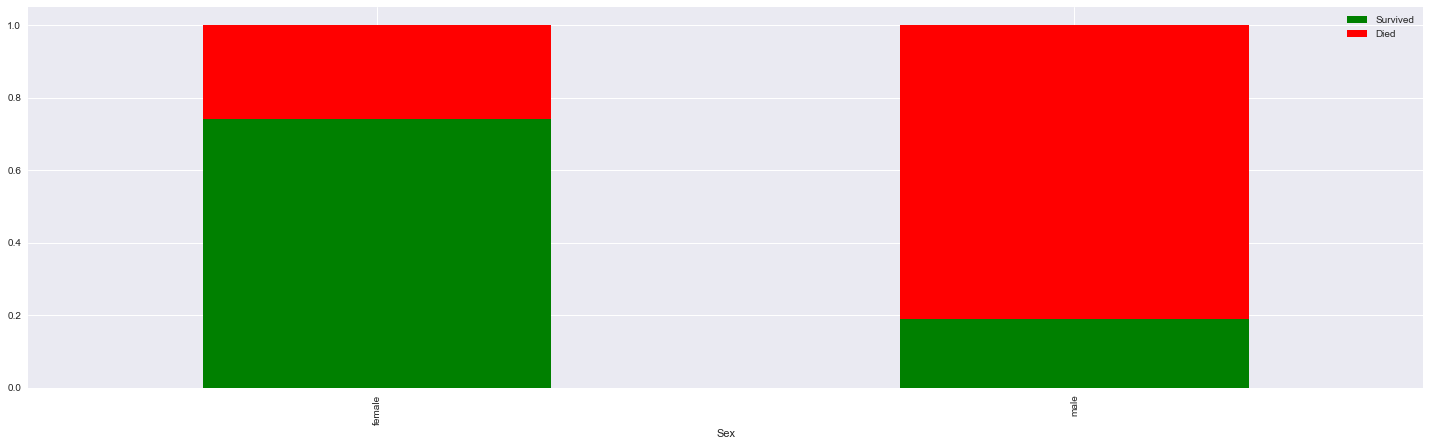

In [732]:
df_all['Died'] = 1 - df_all['Survived']

df_all.groupby('Sex').agg('mean')[['Survived', 'Died']].plot(kind='bar', figsize=(25, 7), 
                                                           stacked=True, color=['g', 'r']);

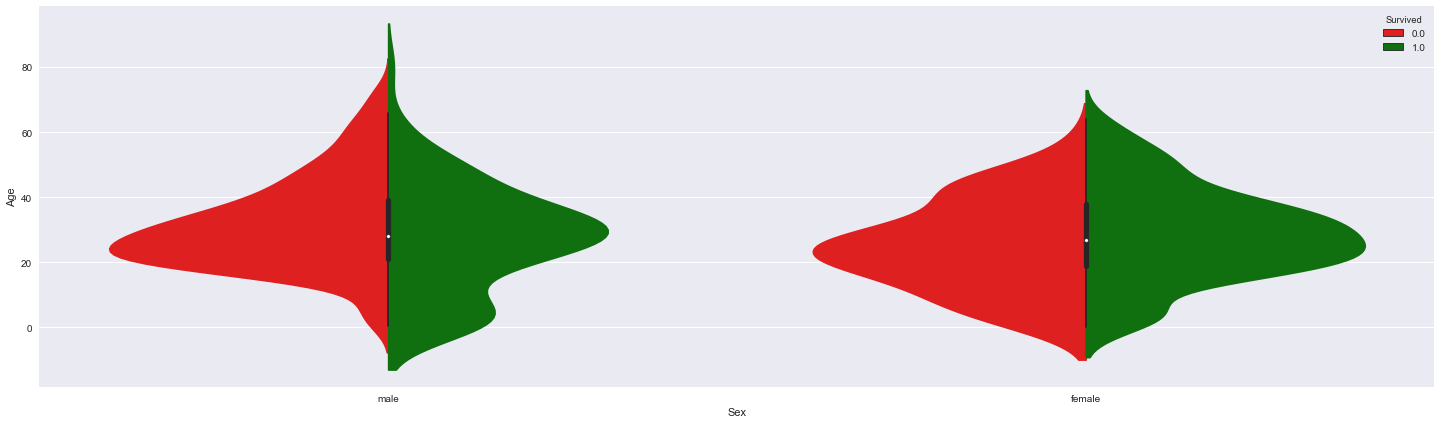

In [733]:
fig = plt.figure(figsize=(25, 7))
sns.violinplot(x='Sex', y='Age', 
               hue='Survived', data=df_all, 
               split=True,
               palette={0: "r", 1: "g"}
              );

# Survival based on ticket 'Fare'

Passengers with cheaper tickets fares were more likely to die. On the other hand passengers with more expensive tickets had bigger chance to survive.

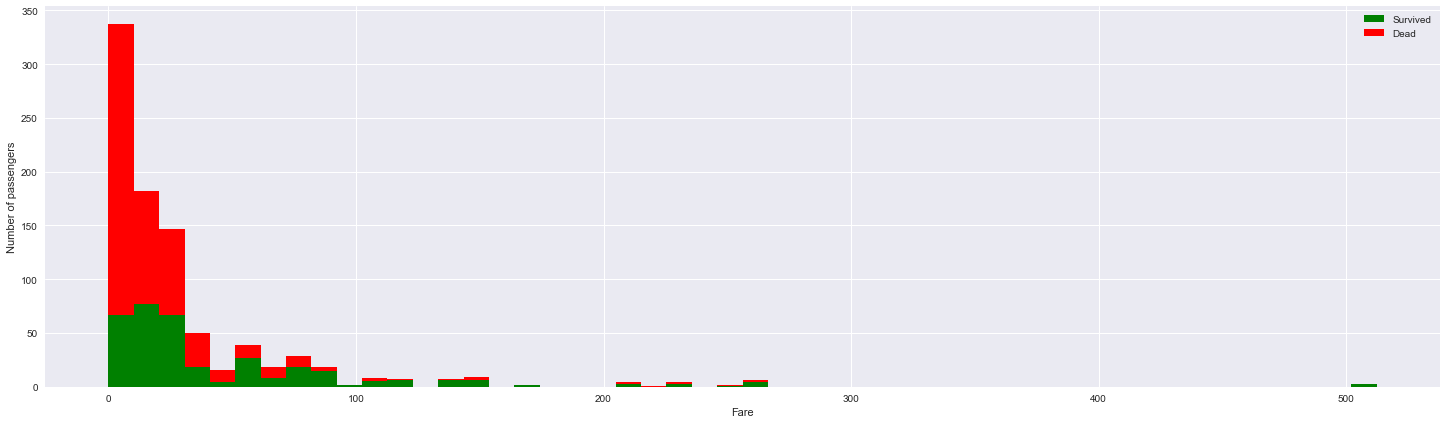

In [734]:
figure = plt.figure(figsize=(25, 7))
plt.hist([df_all[df_all['Survived'] == 1]['Fare'], df_all[df_all['Survived'] == 0]['Fare']], 
         stacked=True, color = ['g','r'],
         bins = 50, label = ['Survived','Dead'])
plt.xlabel('Fare')
plt.ylabel('Number of passengers')
plt.legend();

## First dummy sample - ASAP to kaggle

In [735]:
feats = [ 'Pclass' ]

X = df_train[ feats ].values
y = df_train['Survived'].values

In [736]:
model = ExtraTreesClassifier(n_estimators=100, max_depth=4)
model.fit(X, y)
y_pred = model.predict(X)

score = accuracy_score(y, y_pred)

In [737]:
X = df_test[ feats ].values

predictions = df_test['Survived'] = model.predict(X)

PassengerId = df_test['PassengerId']

submission = pd.DataFrame({ 'PassengerId': PassengerId, 'Survived': predictions })
submission.to_csv("../output/titanic/extra_tree_1_feature.csv", index=False)

print("Our features: %s" % feats)
print("Local Score %.2f" % score)
print("Kaggle Score %.2f" % 0.65)

Our features: ['Pclass']
Local Score 0.68
Kaggle Score 0.65


## Second dummy sample - ASAP to kaggle

In [738]:
feats = df_train.select_dtypes(include=[np.int64]).columns.values
black_list = ['PassengerId', 'Survived'] 

feats = [feat for feat in feats if feat not in black_list]

In [739]:
X = df_train[ feats ].values
y = df_train['Survived'].values

model = ExtraTreesClassifier(n_estimators=100, max_depth=4)
model.fit(X, y)
y_pred = model.predict(X)

score = accuracy_score(y, y_pred)

In [740]:
X = df_test[ feats ].values

predictions = df_test['Survived'] = model.predict(X)

PassengerId = df_test['PassengerId']

submission = pd.DataFrame({ 'PassengerId': PassengerId, 'Survived': predictions })
submission.to_csv("../output/titanic/extra_tree_3_features.csv", index=False)

print("Our features: %s" % feats)
print("Local Score %.2f" % score)
print("Kaggle Score %.2f" % 0.68)

Our features: ['Pclass', 'SibSp', 'Parch']
Local Score 0.71
Kaggle Score 0.68


## Create few helpers

In [741]:
black_list = ['PassengerId', 'Survived']
PassengerId = df_test['PassengerId']


In [766]:

def get_feats(df):
#     feats = df.select_dtypes(include=[np.int64]).columns.values
    feats = features
    
    black_list = ['PassengerId', 'Survived']
    
    return [feat for feat in feats if feat not in black_list]

def train_and_predict(model):
    feats = get_feats( df_train.select_dtypes(include=[np.int, np.float]).head() )
    print('Our features: %s ' % feats)

    X = df_train[ feats ].values
    y = df_train['Survived'].values

#     model = RandomForestClassifier(max_depth=3, n_estimators=100, random_state=1)        
    model.fit(X, y)
    y_pred = model.predict(X)
    
    cross_score = cross_val_score(model, X, y, scoring='accuracy', cv=3)
    plot_result(model, cross_validate(model, X, y, scoring='accuracy', cv=3))

    print('Cross-Validation Score %.2f' %cross_score.mean())
    print('Accuracy Score %.2f' %accuracy_score(y, y_pred))
    
    return model

def predict_and_submit(model, feats, file_name):
    predictions = df_test[ 'Survived' ] = model.predict( df_test[ feats ].values )

    submission = pd.DataFrame({ 'PassengerId': PassengerId, 'Survived': predictions })
    submission.to_csv( '../output/titanic/' + file_name + '.csv', index=False )
    
def feature_engineering(df):
    df['name_length'] = df['Name'].apply(len)
    
    return df

def train_predict_and_create_submission(file_name, model):
    feature_engineering(df_train)
    feature_engineering(df_test)
    
    predict_and_submit( train_and_predict(model) , get_feats(df_test) , file_name)

# Default model

In [743]:

model = RandomForestClassifier(max_depth=3, n_estimators=100, random_state=1)


# FEATURE ENGINEERING

## Name length

In [744]:
features = ['Pclass', 'SibSp', 'Parch', 'name_length'] 

train_predict_and_create_submission('titanic_73', model)
print("Kaggle Score %.2f" % 0.69)

Our features: ['Pclass', 'SibSp', 'Parch', 'name_length'] 
Cross-Validation Score 0.71
Accuracy Score 0.74
Kaggle Score 0.69


## Sex & Embarked

In [745]:
def feature_engineering(df):
    df['sex_cat'] = pd.factorize( df['Sex'] )[0]
    df['embarked_cat'] = pd.factorize( df['Embarked'].fillna('C') )[0] # Fill missing values with 'C'

In [746]:
features = ['Pclass', 'SibSp', 'Parch', 'name_length', 'sex_cat', 'embarked_cat'] 

train_predict_and_create_submission('titanic_82', model)
print("Kaggle Score %.2f" % 0.76)

Our features: ['Pclass', 'SibSp', 'Parch', 'name_length', 'sex_cat', 'embarked_cat'] 
Cross-Validation Score 0.81
Accuracy Score 0.82
Kaggle Score 0.76


## Title

In [747]:
def feature_engineering(df):
    df['title_cat'] = df['Name'].map(lambda x: x.split(',')[1].split('.')[0].strip())
    rare_titles = ['Mlle','the Countess','Mme', 'Ms', 'Lady', 'Countess', 'Capt','Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'] 
    df['title_cat'].values[df['title_cat'].isin( rare_titles )] = 'Rare'
    df['title_cat'] = pd.factorize( df['title_cat'] )[0]

In [748]:
features = ['Pclass', 'SibSp', 'Parch', 'name_length', 'sex_cat', 'embarked_cat', 'title_cat'] 

train_predict_and_create_submission('titanic_82_title_cat', model)
print("Kaggle Score %.2f" % 0.77)

Our features: ['Pclass', 'SibSp', 'Parch', 'name_length', 'sex_cat', 'embarked_cat', 'title_cat'] 
Cross-Validation Score 0.81
Accuracy Score 0.82
Kaggle Score 0.77


## Age

In [749]:
df_train['Age'].isnull().any() # Some data is missing

True

In [750]:
def fill_missing_age(df):
    for i in range(1,4):
        median_age=df[df["title_cat"]==i]["Age"].median()
        df["Age"]=df["Age"].fillna(median_age)
        return df

def feature_engineering(df):
    df = fill_missing_age(df)

In [751]:
features = ['Pclass', 'SibSp', 'Parch', 'name_length', 'sex_cat', 'embarked_cat', 'title_cat', 'Age'] 

train_predict_and_create_submission('titanic_82_Age', model)
print("Kaggle Score %.2f" % 0.77)

Our features: ['Pclass', 'SibSp', 'Parch', 'name_length', 'sex_cat', 'embarked_cat', 'title_cat', 'Age'] 
Cross-Validation Score 0.82
Accuracy Score 0.83
Kaggle Score 0.77


## Fare

In [752]:
def feature_engineering(df):
    df['fare_log'] = np.log2( df['Fare'] + 1 ).fillna(1)

In [753]:
features = ['Pclass', 'SibSp', 'Parch', 'name_length', 'sex_cat', 'embarked_cat', 'title_cat', 'Age', 'fare_log'] 

train_predict_and_create_submission('titanic_82_fare', model)
print("Kaggle Score %.2f" % 0.78468)

Our features: ['Pclass', 'SibSp', 'Parch', 'name_length', 'sex_cat', 'embarked_cat', 'title_cat', 'Age', 'fare_log'] 
Cross-Validation Score 0.82
Accuracy Score 0.82
Kaggle Score 0.78


## Family Size & Cabin

In [754]:
def feature_engineering(df):
    df["FamilySize"] = df["SibSp"] + df["Parch"] + 1

    df['Single'] = df['FamilySize'].map(lambda s: 1 if s == 1 else 0)
    df['SmallF'] = df['FamilySize'].map(lambda s: 1 if s == 2  else 0)
    df['MedF']   = df['FamilySize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
    df['LargeF'] = df['FamilySize'].map(lambda s: 1 if s >= 5 else 0)
    
    df['cabin_norm'] = df['Cabin'].map(lambda x: 'missing' if str(x) == 'nan' else x[0] )
    df['cabin_norm_cat'] = pd.factorize( df['cabin_norm'] )[0]


In [755]:
features = ['Pclass', 'SibSp', 'Parch', 'name_length', 'sex_cat', 'cabin_norm_cat',
            'embarked_cat', 'title_cat', 'Age', 'fare_log', 'FamilySize', 'Single',
            'SmallF', 'MedF','LargeF', 'SibSp', 'Parch'] 

train_predict_and_create_submission('titanic_82_familySize_cabin', model)
print("Kaggle Score %.2f" % 0.77)

Our features: ['Pclass', 'SibSp', 'Parch', 'name_length', 'sex_cat', 'cabin_norm_cat', 'embarked_cat', 'title_cat', 'Age', 'fare_log', 'FamilySize', 'Single', 'SmallF', 'MedF', 'LargeF', 'SibSp', 'Parch'] 
Cross-Validation Score 0.83
Accuracy Score 0.84
Kaggle Score 0.77


# XGBClassifier

Our features: ['Pclass', 'SibSp', 'Parch', 'name_length', 'sex_cat', 'cabin_norm_cat', 'embarked_cat', 'title_cat', 'Age', 'fare_log', 'FamilySize', 'SibSp', 'Parch'] 


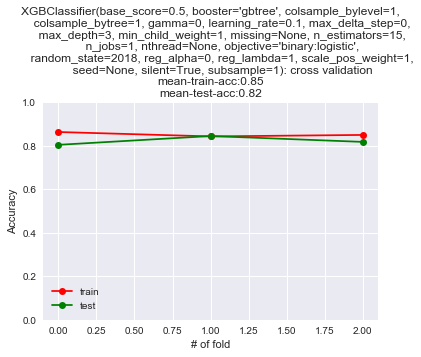

Cross-Validation Score 0.82
Accuracy Score 0.85
Kaggle Score 0.78


In [768]:
model = xgb.XGBClassifier(max_depth=3, n_estimators=15, random_state=2018)

train_predict_and_create_submission('titanic_82_xgb_5', model)
print("Kaggle Score %.2f" % 0.78468)

# Feature Importance

In [757]:

# features = pd.DataFrame()
# features['feature'] = feats
# features['importance'] = model.feature_importances_
# features.sort_values(by=['importance'], ascending=True, inplace=True)
# features.set_index('feature', inplace=True)
# features.plot(kind='barh', figsize=(25, 25))


In [765]:
def plot_result(model_name, result, ylim=(0, 1.)):
    mean_train = np.round( np.mean(result['train_score']), 2 )
    mean_test = np.round( np.mean(result['test_score']), 2 )
    
    plt.title('{0}: cross validation\nmean-train-acc:{1}\nmean-test-acc:{2}'.format(model_name, mean_train, mean_test))
    plt.plot( result['train_score'], 'r-o', label="train" )
    plt.plot( result['test_score'], 'g-o', label="test" )
    plt.legend(loc='best')
    plt.ylabel('Accuracy')
    plt.xlabel('# of fold')
    plt.ylim(*ylim)
    plt.show()

# Hyperparameters tuning

Our features: ['Pclass', 'SibSp', 'Parch', 'name_length', 'sex_cat', 'cabin_norm_cat', 'embarked_cat', 'title_cat', 'Age', 'fare_log', 'FamilySize', 'SibSp', 'Parch'] 


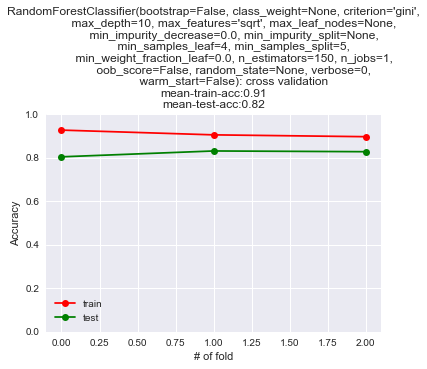

Cross-Validation Score 0.82
Accuracy Score 0.91


In [771]:
parameters = {'bootstrap': False, 'min_samples_leaf': 4, 'n_estimators': 150, 
              'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 10}

features = ['Pclass', 'SibSp', 'Parch', 'name_length', 'sex_cat', 'cabin_norm_cat',
            'embarked_cat', 'title_cat', 'Age', 'fare_log', 'FamilySize', 'SibSp', 'Parch'] 

model = RandomForestClassifier(**parameters)

train_predict_and_create_submission('titanic_82_hyper', model)

In [764]:
print('Train columns with null values:\n', df_train.isnull().sum())
print("-"*10)

print('Test/Validation columns with null values:\n', df_test.isnull().sum())
print("-"*10)

data_raw.describe(include = 'all')

Train columns with null values:
 PassengerId         0
Survived            0
Pclass              0
Name                0
Sex                 0
Age                 0
SibSp               0
Parch               0
Ticket              0
Fare                0
Cabin             687
Embarked            2
name_length         0
sex_cat             0
embarked_cat        0
title_cat           0
fare_log            0
FamilySize          0
Single              0
SmallF              0
MedF                0
LargeF              0
cabin_norm          0
cabin_norm_cat      0
dtype: int64
----------
Test/Validation columns with null values:
 PassengerId         0
Pclass              0
Name                0
Sex                 0
Age                 0
SibSp               0
Parch               0
Ticket              0
Fare                1
Cabin             327
Embarked            0
Survived            0
name_length         0
sex_cat             0
embarked_cat        0
title_cat           0
fare_log            

NameError: name 'data_raw' is not defined

<br><br><br>


# Materials:
You can find summary of it on my Polish blog.
* [Pierwsze dwa projekty Machine Learningowe by Łukasz Sroczyński](http://www.braintelligence.pl/pierwsze-dwa-projekty-machine-learningowe)

<br>

### Other
* [Praktyczne uczenie maszynowe w przykładach (Titanic) - Webinar](https://youtu.be/GvuxM3z4xU4)
* [Tutorial - How to archive 88%](https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy/notebook)
* [How to score 0.8134 in Titanic Kaggle Challenge](https://ahmedbesbes.com/how-to-score-08134-in-titanic-kaggle-challenge.html)
* [Comparing ML algorithms](https://www.kaggle.com/aldemuro/comparing-ml-algorithms-train-accuracy-90/notebook)
* [Titanic Data Science Solutions](https://www.kaggle.com/startupsci/titanic-data-science-solutions/notebook)
<br>
<br>
<br>